In [1]:
import os
import pandas as pd
import sqlite3

##### STEP 1 & 2 IS AUTHORED BY UJWAL JIBHKATE (ujibhkat@iu.edu)

### Step 1: Import Libraries and Load the Main CSV File

In [89]:
# Author: Ujwal Jibhkate (ujibhkat@iu.edu)

csv_path = 'part_1.csv'
df = pd.read_csv(csv_path, low_memory=False)
df.dropna(inplace=True)
df = df.head(100000)
print("DataFrame loaded with shape:", df.shape)

DataFrame loaded with shape: (100000, 19)


In [90]:
# Author: Ujwal Jibhkate (ujibhkat@iu.edu)

df.columns

Index(['recordId', 'callKey', 'callDateTime', 'priority', 'district',
       'description', 'callNumber', 'incidentLocation', 'location',
       'Neighborhood', 'PoliceDistrict', 'PolicePost', 'CouncilDistrict',
       'SheriffDistricts', 'Community_Statistical_Areas', 'Census_Tracts',
       'ZIPCode', 'NeedsSync', 'ESRI_OID'],
      dtype='object')

### Step 2: Create the SQLite Database and Tables
###
### We now create a SQLite3 database file and define our four tables.


In [2]:
# Author: Ujwal Jibhkate (ujibhkat@iu.edu)

db_path = "911_Call_Data.db" 
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

### Jurisdiction Table

In [92]:
# Author: Ujwal Jibhkate (ujibhkat@iu.edu)

cursor.execute("""
CREATE TABLE IF NOT EXISTS Jurisdictions (
    jurisdiction_id INTEGER PRIMARY KEY AUTOINCREMENT,
    district TEXT,
    police_district TEXT,
    police_post TEXT,
    council_district TEXT,
    sheriff_district TEXT,
    UNIQUE(district, police_district, police_post, council_district, sheriff_district)
);
""")

### Locations Table

In [93]:
# Author: Ujwal Jibhkate (ujibhkat@iu.edu)

cursor.execute("""
CREATE TABLE IF NOT EXISTS Locations (
    location_id INTEGER PRIMARY KEY AUTOINCREMENT,
    address TEXT,
    neighborhood TEXT,
    zip_code TEXT,
    census_tract TEXT,
    community_statistical_area TEXT,
    UNIQUE(address, neighborhood, zip_code, census_tract, community_statistical_area)
);
""")

### Calls table

In [94]:
# Author: Ujwal Jibhkate (ujibhkat@iu.edu)

cursor.execute("""
CREATE TABLE IF NOT EXISTS Calls (
    call_key TEXT PRIMARY KEY,
    record_id TEXT,
    call_date_time TEXT,  -- stored as TEXT (ISO format) in SQLite
    priority TEXT,
    description TEXT,
    call_number TEXT,
    incident_location_id INTEGER,
    reporter_location_id INTEGER,
    jurisdiction_id INTEGER,
    FOREIGN KEY (incident_location_id) REFERENCES Locations(location_id),
    FOREIGN KEY (reporter_location_id) REFERENCES Locations(location_id),
    FOREIGN KEY (jurisdiction_id) REFERENCES Jurisdictions(jurisdiction_id)
);
""")

### ArcGIS_Metadata Table

In [95]:
# Author: Ujwal Jibhkate (ujibhkat@iu.edu)

cursor.execute("""
CREATE TABLE IF NOT EXISTS ArcGIS_Metadata (
    call_key TEXT PRIMARY KEY,
    needs_sync INTEGER,  -- booleans stored as 0 (False) or 1 (True)
    esri_oid INTEGER,
    FOREIGN KEY (call_key) REFERENCES Calls(call_key)
);
""")

In [96]:
# Author: Ujwal Jibhkate (ujibhkat@iu.edu)

conn.commit()
print("Database and tables created.")

Database and tables created.


##### STEP 3 IS AUTHORED BY ARNAV JAIN (aj180@iu.edu) AND SACHIN KUMAR (kumasach@iu.edu)

## Step 3: Process the CSV Data and Insert Data into SQLite Tables

In [ ]:
# Author: Arnav Jain (aj180@iu.edu)

def clean_field(value):
    """Convert None or NaN values to empty strings and ensure a string type for key consistency."""
    if pd.isnull(value):
        return ""
    try:
        if isinstance(value, float) and value.is_integer():
            return str(int(value))
    except Exception:
        pass
    return str(value).strip()

In [ ]:
# Author: Arnav Jain (aj180@iu.edu)

jurisdictions_cache = {}
locations_cache = {}

def get_or_create_location(address, neighborhood, zip_code, census_tract, community_statistical_area):
    address = clean_field(address)
    neighborhood = clean_field(neighborhood)
    zip_code = clean_field(zip_code)
    census_tract = clean_field(census_tract)
    community_statistical_area = clean_field(community_statistical_area)
    
    key = (address, neighborhood, zip_code, census_tract, community_statistical_area)
    if key in locations_cache:
        return locations_cache[key]
    
    cursor.execute("""
        INSERT OR IGNORE INTO Locations (address, neighborhood, zip_code, census_tract, community_statistical_area)
        VALUES (?, ?, ?, ?, ?)
    """, key)
    cursor.execute("""
        SELECT location_id FROM Locations 
        WHERE address=? AND neighborhood=? AND zip_code=? AND census_tract=? AND community_statistical_area=?
    """, key)
    result = cursor.fetchone()
    if result is None:
        raise Exception("Error retrieving location with key: " + str(key))
    location_id = result[0]
    locations_cache[key] = location_id
    return location_id

In [ ]:
# Author: Arnav Jain (aj180@iu.edu)

def get_or_create_jurisdiction(row):
    key = (row["district"], row["PoliceDistrict"], row["PolicePost"], row["CouncilDistrict"], row["SheriffDistricts"])
    if key in jurisdictions_cache:
        return jurisdictions_cache[key]
    cursor.execute("""
    INSERT OR IGNORE INTO Jurisdictions (district, police_district, police_post, council_district, sheriff_district)
    VALUES (?, ?, ?, ?, ?)
    """, key)
    cursor.execute("""
    SELECT jurisdiction_id FROM Jurisdictions 
    WHERE district=? AND police_district=? AND police_post=? AND council_district=? AND sheriff_district=?
    """, key)
    result = cursor.fetchone()
    if result is None:
        raise Exception("Error retrieving jurisdiction with key: " + str(key))
    jurisdiction_id = result[0]
    jurisdictions_cache[key] = jurisdiction_id
    return jurisdiction_id

In [ ]:
# Author: Sachin Kumar (kumasach@iu.edu)

skipped_records = 0
processed_records = 0

for index, row in df.iterrows():
    try:

        cursor.execute("SAVEPOINT rec_savepoint")

        if pd.isnull(row["callKey"]):
            cursor.execute("ROLLBACK TO rec_savepoint")
            cursor.execute("RELEASE rec_savepoint")
            skipped_records += 1
            continue
        

        jurisdiction_id = get_or_create_jurisdiction(row)
        

        reporter_location_id = get_or_create_location(
            row["location"],
            row["Neighborhood"],
            row["ZIPCode"],
            row["Census_Tracts"],
            row["Community_Statistical_Areas"]
        )
        
 
        incident_location_id = get_or_create_location(
            row["incidentLocation"],
            None, None, None, None
        )
        

        cursor.execute("""
            INSERT OR IGNORE INTO Calls 
            (call_key, record_id, call_date_time, priority, description, call_number, incident_location_id, reporter_location_id, jurisdiction_id)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
        """, (
            row["callKey"],
            str(row["recordId"]),   # Preserved as text from CSV.
            row["callDateTime"],     # Assumed to be an ISO-format or comparable date/time string.
            row["priority"],
            row["description"],
            row["callNumber"],
            incident_location_id,
            reporter_location_id,
            jurisdiction_id
        ))
        

        ns_val = str(row["NeedsSync"]).strip()
        needs_sync = 1 if ns_val in ["1", "1.0", "True"] else 0
        try:
            esri_oid = int(float(row["ESRI_OID"])) if not pd.isnull(row["ESRI_OID"]) else None
        except:
            esri_oid = None
        
        cursor.execute("""
            INSERT OR IGNORE INTO ArcGIS_Metadata (call_key, needs_sync, esri_oid)
            VALUES (?, ?, ?)
        """, (
            row["callKey"],
            needs_sync,
            esri_oid
        ))
        
   
        cursor.execute("RELEASE rec_savepoint")
        processed_records += 1
    except Exception as e:
        cursor.execute("ROLLBACK TO rec_savepoint")
        cursor.execute("RELEASE rec_savepoint")
        skipped_records += 1
        continue

conn.commit()
print(f"Processing complete. Processed: {processed_records} records, Skipped: {skipped_records} records.")

Processing complete. Processed: 100000 records, Skipped: 0 records.


In [ ]:
# Author: Arnav Jain (aj180@iu.edu)

cursor.execute("SELECT Count(*) FROM Calls;")
count = cursor.fetchall()
print("Record Count from Calls table:")
for row in count:
    print(row)

Record Count from Calls table:
(99259,)


In [ ]:
# Author: Arnav Jain (aj180@iu.edu)

cursor.execute("SELECT COUNT(*) FROM Jurisdictions;")
count = cursor.fetchall()
print("Record Count from Jurisdictions table:")
for row in count:
    print(row)

Record Count from Jurisdictions table:
(1046,)


In [ ]:
# Author: Arnav Jain (aj180@iu.edu)

cursor.execute("SELECT COUNT(*) FROM Locations;")
count = cursor.fetchall()
print("Record Count from Locations table:")
for row in count:
    print(row)

Record Count from Locations table:
(40071,)


In [ ]:
# Author: Arnav Jain (aj180@iu.edu)

cursor.execute("SELECT COUNT(*) FROM ArcGIS_Metadata;")
count = cursor.fetchall()
print("Record Count from ArcGIS Metadata table:")
for row in count:
    print(row)

Record Count from ArcGIS Metadata table:
(100000,)


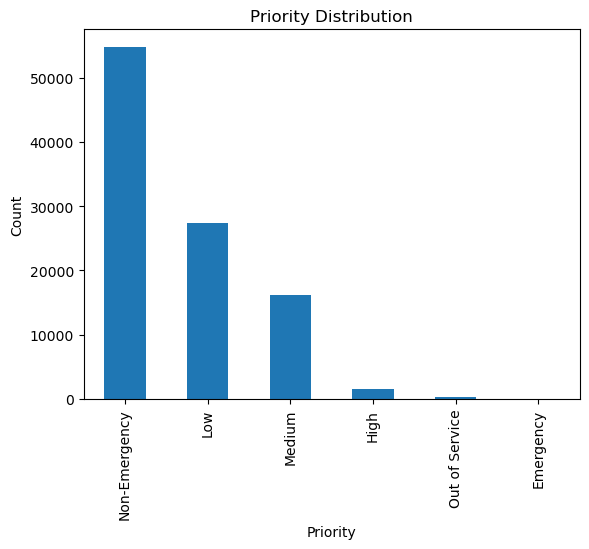

In [ ]:
# Author: Sachin Kumar (kumasach@iu.edu)

import matplotlib.pyplot as plt

df_calls = pd.read_sql_query("SELECT * FROM Calls;", conn)
#print(df_calls)


priority_counts = df_calls['priority'].value_counts()
priority_counts.plot(kind='bar')
plt.xlabel('Priority')
plt.ylabel('Count')
plt.title('Priority Distribution')
plt.show()



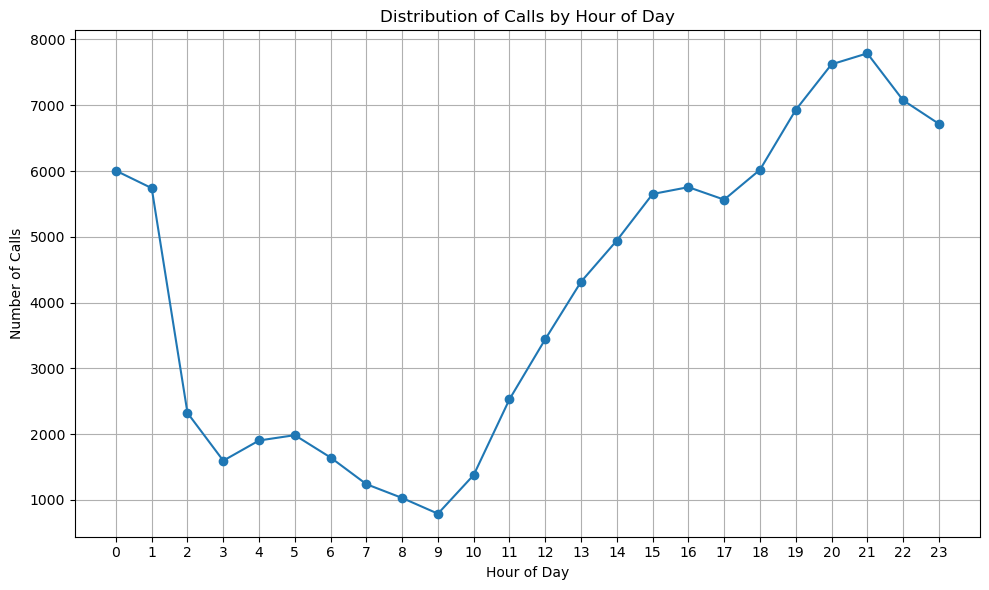

In [4]:
# Author: Sachin Kumar (kumasach@iu.edu)

query_time = "SELECT call_date_time FROM Calls;"
df_times = pd.read_sql_query(query_time, conn)

df_times['call_date_time'] = pd.to_datetime(df_times['call_date_time'], errors='coerce')
df_times = df_times.dropna(subset=['call_date_time'])
df_times['hour'] = df_times['call_date_time'].dt.hour

df_hourly = df_times.groupby('hour').size().reset_index(name="count")

plt.figure(figsize=(10, 6))
plt.plot(df_hourly['hour'], df_hourly['count'], marker="o", linestyle="-")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Calls")
plt.title("Distribution of Calls by Hour of Day")
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()

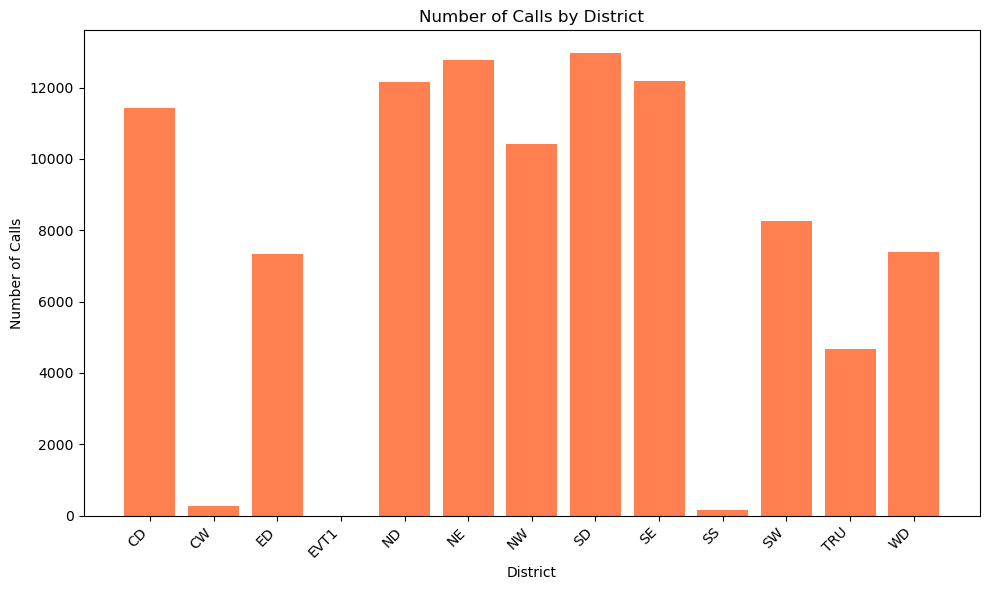

In [5]:
# Author: Sachin Kumar (kumasach@iu.edu)

query_district = """
SELECT J.district, COUNT(*) as count
FROM Calls C
JOIN Jurisdictions J ON C.jurisdiction_id = J.jurisdiction_id
GROUP BY J.district;
"""
df_district = pd.read_sql_query(query_district, conn)

plt.figure(figsize=(10, 6))
plt.bar(df_district["district"], df_district["count"], color="coral")
plt.xlabel("District")
plt.ylabel("Number of Calls")
plt.title("Number of Calls by District")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

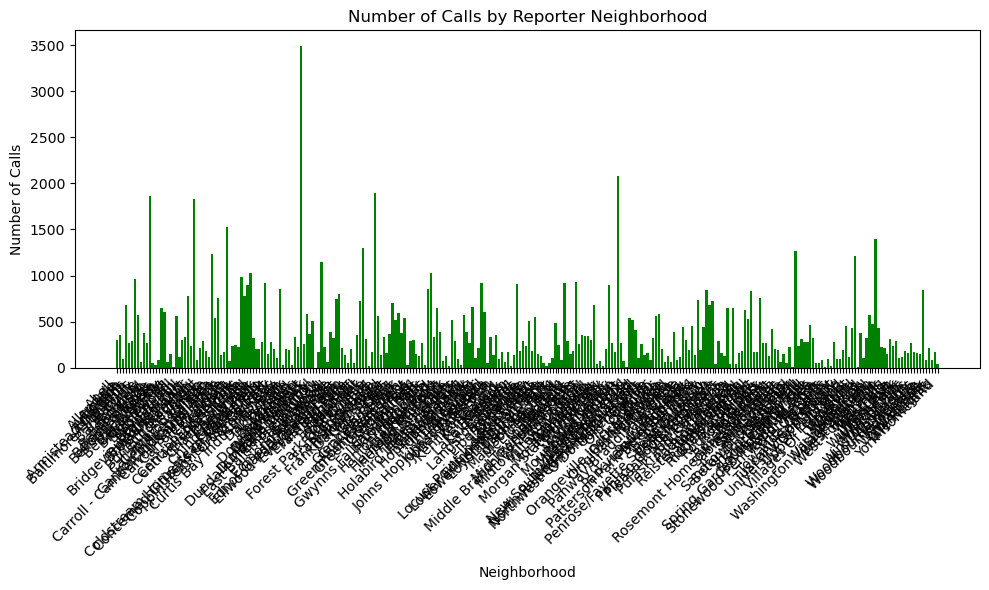

In [7]:
# Author: Sachin Kumar (kumasach@iu.edu)

query_neighborhood = """
SELECT L.neighborhood, COUNT(*) AS count
FROM Calls C
JOIN Locations L ON C.reporter_location_id = L.location_id
GROUP BY L.neighborhood;
"""

# Load the results into a DataFrame
df_neighborhood = pd.read_sql_query(query_neighborhood, conn)

# Plotting the bar chart for Number of Calls by Neighborhood
plt.figure(figsize=(10, 6))
plt.bar(df_neighborhood["neighborhood"], df_neighborhood["count"], color="green")
plt.xlabel("Neighborhood")
plt.ylabel("Number of Calls")
plt.title("Number of Calls by Reporter Neighborhood")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
conn.close()